In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Skoda.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Citigo,Seri_Fabia,Seri_Favorit,...,Model_2.0 TDI RS,Model_2.5 TDI Elegance,Model_GLX,Model_LX,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,77500,1993,58,1289,350000,12.0,0.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1559750,2020,101,1601,26900,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,765000,2017,115,1598,175000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1059500,2017,120,1598,109000,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,875000,2015,110,1598,64000,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_8196\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,66577.998654,5.437357e+09,73738.433258,46729.676484


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:23:48,098] A new study created in memory with name: no-name-11fcec60-5c6a-49a7-b114-e3dc949a0f8c
[I 2023-10-08 14:23:48,300] Trial 3 finished with value: 668013.7405430059 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.001744760864926209, 'max_depth': 11, 'min_child_weight': 212}. Best is trial 3 with value: 668013.7405430059.
[I 2023-10-08 14:23:48,303] Trial 4 finished with value: 360423.90452368837 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.08607914919108332, 'max_depth': 7, 'min_child_weight': 264}. Best is trial 4 with value: 360423.90452368837.
[I 2023-10-08 14:23:48,312] Trial 2 finished with value: 415506.6094097535 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.05935902838191706, 'max_depth': 14, 'min_child_weight': 194}. Best is trial 4 with value: 360423.90452368837.
[I 2023-10-08 14:23:48,315] Trial 7 finished with value: 649097.2386123238 and parameters: {'c

[I 2023-10-08 14:23:49,571] Trial 29 finished with value: 198724.81170731038 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.148767487117962, 'max_depth': 4, 'min_child_weight': 172}. Best is trial 23 with value: 111465.26252918775.
[I 2023-10-08 14:23:49,581] Trial 30 finished with value: 190034.7195117938 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.15583682334145654, 'max_depth': 4, 'min_child_weight': 175}. Best is trial 23 with value: 111465.26252918775.
[I 2023-10-08 14:23:49,604] Trial 32 finished with value: 198799.80789756024 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.14472563132950692, 'max_depth': 4, 'min_child_weight': 135}. Best is trial 23 with value: 111465.26252918775.
[I 2023-10-08 14:23:49,663] Trial 33 finished with value: 166666.68064510095 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.1841149570328135, 'max_depth': 4, 'min_child_weig

[I 2023-10-08 14:23:51,062] Trial 60 finished with value: 148716.9598230363 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3303339914709754, 'max_depth': 3, 'min_child_weight': 300}. Best is trial 23 with value: 111465.26252918775.
[I 2023-10-08 14:23:51,261] Trial 61 finished with value: 290485.19151867466 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.104924673740757, 'max_depth': 5, 'min_child_weight': 250}. Best is trial 23 with value: 111465.26252918775.
[I 2023-10-08 14:23:51,300] Trial 62 finished with value: 143735.25766406837 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.3386891095332534, 'max_depth': 5, 'min_child_weight': 250}. Best is trial 23 with value: 111465.26252918775.
[I 2023-10-08 14:23:51,355] Trial 63 finished with value: 148253.34571127835 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.29680160217595114, 'max_depth': 5, 'min_child_weigh

[I 2023-10-08 14:23:52,864] Trial 90 finished with value: 162039.54368355105 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.28110822994414797, 'max_depth': 8, 'min_child_weight': 185}. Best is trial 87 with value: 105601.41107072544.
[I 2023-10-08 14:23:52,926] Trial 91 finished with value: 137827.2100399976 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2509961457519406, 'max_depth': 8, 'min_child_weight': 217}. Best is trial 87 with value: 105601.41107072544.
[I 2023-10-08 14:23:52,991] Trial 92 finished with value: 117664.27705686654 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.2716406072292399, 'max_depth': 8, 'min_child_weight': 106}. Best is trial 87 with value: 105601.41107072544.
[I 2023-10-08 14:23:53,105] Trial 93 finished with value: 93281.14946876327 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.26152636952026354, 'max_depth': 8, 'min_child_weig

[I 2023-10-08 14:23:54,904] Trial 119 finished with value: 78534.50025250424 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3772942134678951, 'max_depth': 9, 'min_child_weight': 15}. Best is trial 119 with value: 78534.50025250424.
[I 2023-10-08 14:23:54,952] Trial 120 finished with value: 81870.83643378923 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.35086604413166783, 'max_depth': 9, 'min_child_weight': 13}. Best is trial 119 with value: 78534.50025250424.
[I 2023-10-08 14:23:55,003] Trial 122 finished with value: 81687.907223479 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.33980192665358994, 'max_depth': 9, 'min_child_weight': 13}. Best is trial 119 with value: 78534.50025250424.
[I 2023-10-08 14:23:55,028] Trial 124 finished with value: 82745.48731129136 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3239039833737611, 'max_depth': 9, 'min_child_weight'

[I 2023-10-08 14:23:56,666] Trial 150 finished with value: 74005.52347199582 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.48884943208285836, 'max_depth': 10, 'min_child_weight': 2}. Best is trial 148 with value: 73705.39621881273.
[I 2023-10-08 14:23:57,034] Trial 151 finished with value: 79678.30419433846 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.478600905670333, 'max_depth': 11, 'min_child_weight': 19}. Best is trial 148 with value: 73705.39621881273.
[I 2023-10-08 14:23:57,049] Trial 152 finished with value: 79783.89871991762 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.49670091293382734, 'max_depth': 11, 'min_child_weight': 19}. Best is trial 148 with value: 73705.39621881273.
[I 2023-10-08 14:23:57,129] Trial 154 finished with value: 81012.2278026978 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4874594487993704, 'max_depth': 11, 'min_child_weig

[I 2023-10-08 14:23:58,937] Trial 180 finished with value: 74487.57985951251 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.41884293191787725, 'max_depth': 10, 'min_child_weight': 4}. Best is trial 176 with value: 73046.45883738855.
[I 2023-10-08 14:23:58,971] Trial 179 finished with value: 72858.81486137393 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.41107513283525243, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 179 with value: 72858.81486137393.
[I 2023-10-08 14:23:58,980] Trial 181 finished with value: 73656.21986666835 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4126319026357037, 'max_depth': 10, 'min_child_weight': 2}. Best is trial 179 with value: 72858.81486137393.
[I 2023-10-08 14:23:59,091] Trial 184 finished with value: 79047.02680145596 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.40803621017229535, 'max_depth': 10, 'min_child_wei

[I 2023-10-08 14:24:01,009] Trial 210 finished with value: 78480.61981061405 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.39601356189314857, 'max_depth': 11, 'min_child_weight': 14}. Best is trial 179 with value: 72858.81486137393.
[I 2023-10-08 14:24:01,136] Trial 211 finished with value: 78890.20684578839 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3979320432606196, 'max_depth': 11, 'min_child_weight': 14}. Best is trial 179 with value: 72858.81486137393.
[I 2023-10-08 14:24:01,345] Trial 213 finished with value: 78272.52648079648 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3398186730527802, 'max_depth': 11, 'min_child_weight': 13}. Best is trial 179 with value: 72858.81486137393.
[I 2023-10-08 14:24:01,373] Trial 212 finished with value: 78890.61259109312 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3411528137305488, 'max_depth': 11, 'min_child_we

[I 2023-10-08 14:24:03,369] Trial 241 finished with value: 73639.64442205105 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.4272381450253249, 'max_depth': 12, 'min_child_weight': 3}. Best is trial 228 with value: 72332.52144639354.
[I 2023-10-08 14:24:03,410] Trial 239 finished with value: 73134.52588436073 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.419950736348377, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 228 with value: 72332.52144639354.
[I 2023-10-08 14:24:03,461] Trial 242 finished with value: 75239.90182051784 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.42148976843355723, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 228 with value: 72332.52144639354.
[I 2023-10-08 14:24:03,508] Trial 243 finished with value: 75269.20052135797 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.42264013897415337, 'max_depth': 12, 'min_child_weigh

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 72332.5214
Best params:
	colsample_bytree: 0.5
	subsample: 0.7
	learning_rate: 0.41550396681194324
	max_depth: 11
	min_child_weight: 6


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 72798.71324450865, 'MSE': 5687204230.636836, 'RMSE': 75413.55468771404, 'MAE': 49447.40120091427}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9578993488237089

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9504578293663983

In [16]:
marka_model = joblib.dump(final_model, "Skoda.pkl")

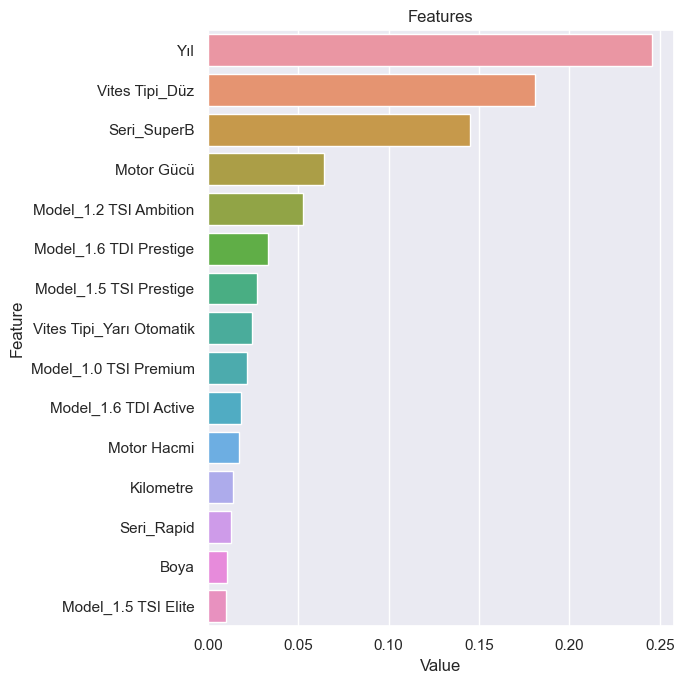

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)